[View in Colaboratory](https://colab.research.google.com/github/alvarogutyerrez/alvarogutyerrez/blob/master/Sesion_5_Gradiente_Decendiente.ipynb)

#Sesión #5 :Gradiente Decendiente. Una pequeña discusión.

La idea general de esta sesión, es aprender la ganancias en términos computacionales a la hora de la estimación de parámetros, haciendo uso del algoritmo de Gradiente Decendiente, en sus diferentes versiones, colores y sabores. La operación de la cual tratamos de escaparnos es de la inversa de una matriz, la cual tiene asociado un elevado costo computacional cuando el rango de la misma es muy elevado. De este modo, mostraremos acá formas alternativas realizar estimaciones ocupar dicha operación.

In [0]:
from __future__ import print_function    # (at top of module)
from __future__ import division
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

from numpy.linalg import inv
import pandas as pd

##Generacion de la Data

Simularemos un modelo lineal <strike>rasca</strike> simple de la forma.
$$ y_i = \alpha + \beta X_i+ e_i $$ 
En donde los valores verdaderos de los parámetros son conocidos e iguales a:
$\alpha= 4$ y $\beta = 3$ más un término de error.

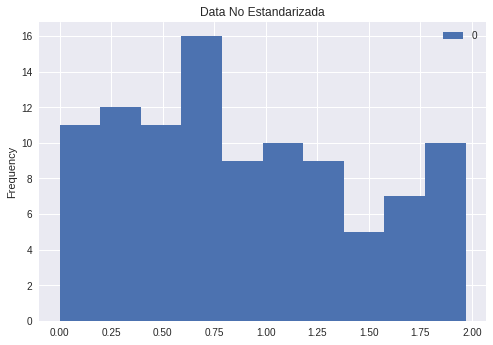

In [3]:
X = 2*np.random.rand(100,1)
mu, sigma = 0, 0.1 # mean and standard deviation
y = 4 + 3*X + np.random.normal(mu, sigma, 100)

 
x_pd = pd.DataFrame(X)
x_pd.plot(kind='hist', title = 'Data No Estandarizada')

Estandarizacion

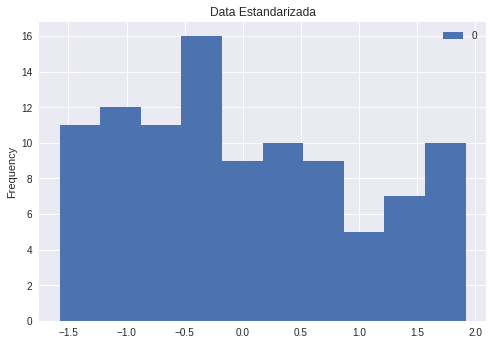

In [4]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

x_pd = pd.DataFrame(X)
x_pd.plot(kind='hist', title = 'Data Estandarizada')

##Estimacion Coeficientes Forma 1: OLS en su forma cerrada (incluye constante)

Esta es la operación más costosa en términos computacionales, debido a que requerimos calcular la inversa de la matríz $(X'X)$.

In [5]:
from numpy.linalg import inv

X_b = np.c_[np.ones((100,1)) , X] #Incluyendo constante
theta_close = inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_close


array([[7.71473427],
       [1.75940446]])

#Estimacion Coeficientes Forma 2: Gradiente Decendiente


##(1) Batch Gradient Descent 

Ocupando toda la muestra va calculando el gradiente en cada iteración. Este algoritmo tiene por un lado la ventaja de que la convergencia es monotónica sobre funciones globalmente convexas. De este modo, podemos apreciar una convergencia ''suave'' hacia los valores verdaderos.

In [0]:
eta = 0.1 #learning rate
n_iter =20

#Numero de Filas 

m = 100
#guess = np.random.randn(2,1) #Numeros aleatorios como guess
guess= np.array([0,0]).reshape(2,1) #Selecciono los numeros aleatorios


In [7]:
learning_curve_GD = []
for iteracion in range(n_iter):
  gradiente = 2/m * X_b.T.dot(X_b.dot(guess) - y )
  guess =guess - eta*gradiente
  list_aux = [guess[0,0], guess[1,0]]
  learning_curve_GD.append(list_aux)

guess



array([[7.62578944],
       [1.73911991]])

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


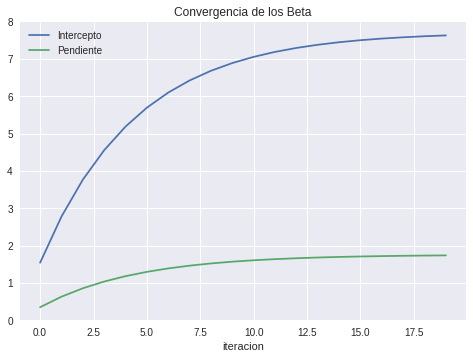

In [8]:
  
learning_curve_GD_pd=pd.DataFrame(learning_curve_GD , columns = ['Intercepto', 'Pendiente'])
learning_curve_GD_pd['iteracion'] = learning_curve_GD_pd.index
graph=learning_curve_GD_pd.plot(x='iteracion',  y=['Intercepto', 'Pendiente'],kind='line',title='Convergencia de los Beta')    


usando sklearn

In [0]:
sdg_reg = SGDRegressor(n_iter = 20 , eta0 =0.1 , fit_intercept = True )
sdg_reg.fit(X,y)

coef = [sdg_reg.intercept_  ,sdg_reg.coef_]
coef

##(2) Stochastic Gradient Descent 

Este algoritmo, a diferencia del anterior, solamente toma una fila aleatoria dentro de la muestra para calcular el gradiente. De esta forma, la complejidad computacional del algoritmo es mucho menor, debido a que no ocupa más que una fila para calcular el gradiente. Lamentablemente, no todo es color de rosa, dado que este algotimo mostratá una convergencia acerruchada hacia los valores reales, por lo que este método no asegura una que convergerá con probabilidad uno a los valores verdaderos, pero puede manejar mejor los mínimos locales de funciones globalmente no cónvacas.


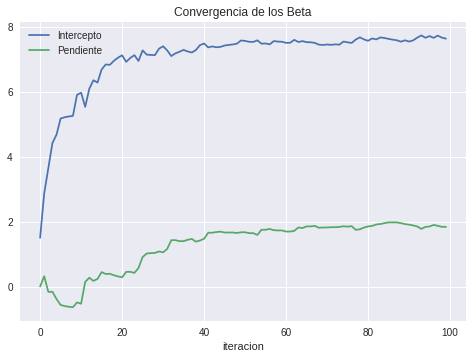

In [10]:
learning_curve_SGD = []

n_epochs = 10
eta = 0.1
m = 10
guess_SGD = np.array([0,0]).reshape(2,1) #Guess Iniciales

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index,:].reshape(1,2)
        yi = y[random_index].reshape(1,1)
        gradients = 2 * xi.T.dot(xi.dot(guess_SGD) - yi)
        guess_SGD = guess_SGD - eta * gradients
        list_aux = [guess_SGD[0,0], guess_SGD[1,0]]
        learning_curve_SGD.append(list_aux)

learning_curve_SGD_pd=pd.DataFrame(learning_curve_SGD , columns = ['Intercepto', 'Pendiente'])
learning_curve_SGD_pd['iteracion'] = learning_curve_SGD_pd.index
graph=learning_curve_SGD_pd.plot(x='iteracion',  y=['Intercepto', 'Pendiente'],kind='line',title='Convergencia de los Beta')    


##(2.1) Stochastic Gradient Descent (with simulated annealing)


La única diferencia con el algoritmo anterior es que este no posee un learning rate fijo. Sino que se va actualizando en cada epoca (epoch). En este case definimos una funcion auxiliar llamada ''annealing'', que irá reduciendo el _eta_, en cada iteración (esto se puede ver en el grafico del eta a lo largo de las iteraciones (m) y generaciones (epoch)). Por otro lado, este algoritmo, al permitir una tasa de convergencia dinámica asegura  que las últimas iteraciones posean un ratio de convergencia menor.

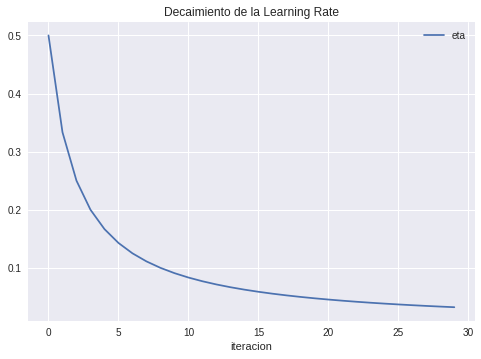

In [11]:

learning_curve_SGD_annealing_eta = []
learning_curve_SGD_annealing_betas = []


n_epochs = 3
m=10
t0, t1 = 1, 2  # learning schedule hyperparameters

def annealing(t):
    return t0 / (t + t1)

guess_SGD_sa =  np.array([0,0]).reshape(2,1) #Guess Iniciales

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index,:].reshape(1,2)
        yi = y[random_index].reshape(1,1)
        gradients = 2 * xi.T.dot(xi.dot(guess_SGD_sa) - yi)
        eta = annealing(epoch * m + i)
        guess_SGD_sa = guess_SGD_sa - eta * gradients
        list_aux_eta = eta
        list_aux_betas = [guess_SGD_sa[0,0], guess_SGD_sa[1,0]]
        learning_curve_SGD_annealing_betas.append(list_aux_betas)
        learning_curve_SGD_annealing_eta.append(list_aux_eta)



learning_curve_SGD_annealing_eta_pd=pd.DataFrame(learning_curve_SGD_annealing_eta , columns = ['eta'])
learning_curve_SGD_annealing_eta_pd['iteracion'] = learning_curve_SGD_annealing_eta_pd.index
graph=learning_curve_SGD_annealing_eta_pd.plot(x='iteracion',  y='eta',kind='line',title='Decaimiento de la Learning Rate')    





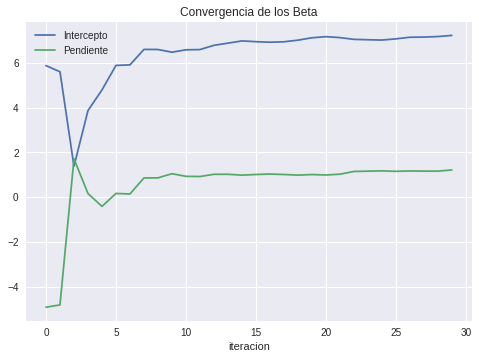

In [12]:

learning_curve_SGD_annealing_betas_pd=pd.DataFrame(learning_curve_SGD_annealing_betas ,columns = ['Intercepto', 'Pendiente'])
learning_curve_SGD_annealing_betas_pd['iteracion'] = learning_curve_SGD_annealing_betas_pd.index
graph=learning_curve_SGD_annealing_betas_pd.plot(x='iteracion',  y=['Intercepto', 'Pendiente'],kind='line',title='Convergencia de los Beta')    
  


##(3) Mini-Batch Gradient Descent 

Este último algoritmo se encuentra entremedio de los dos anteriores. Dado que no toma toda la muestra como Batch GD, ni tampoco una sola fila como Stochastic GD, este algoritmo permite tomar una proporción de la muestra (e.g. 5 filas) en cada iteración y calcular el gradiente correspondiente con dicha sub-muestra.


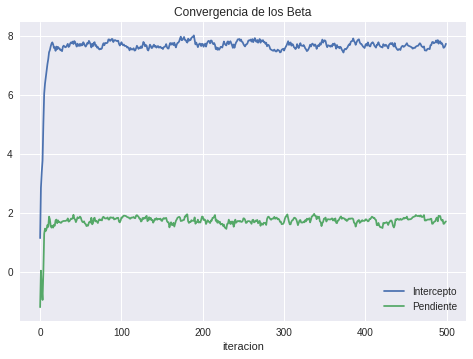

In [13]:
learning_curve_mini_batch = []
n_epochs = 500
eta = 0.1
'''Additional for mini-batch '''
lenght_batch = 1
[row, col]=X_b.shape
'''VALOR INICIAL'''
guess_MB = np.array([0,0]).reshape(2,1) #Guess Iniciales
for epoch in range(n_epochs):
    '''SELECCIONA PORCION ALEATORIA '''       
    idx = np.random.randint(row, size=lenght_batch)
    '''BATCH EN X'''
    x_b= X_b[idx,:].reshape(lenght_batch,col)   
    '''BATCH EN Y'''
    y_b= y[idx,:].reshape(lenght_batch,1)  
    ''' CALCULO DEL GRADIENTE'''              
    gradients = 2 * x_b.T.dot(x_b.dot(guess_MB) - y_b)
    guess_MB = guess_MB - eta * gradients
    list_aux_MB = [guess_MB[0,0], guess_MB[1,0]]
    learning_curve_mini_batch.append(list_aux_MB)


learning_curve_mini_batch_pd=pd.DataFrame(learning_curve_mini_batch , columns = ['Intercepto', 'Pendiente'])
learning_curve_mini_batch_pd['iteracion'] = learning_curve_mini_batch_pd.index
graph=learning_curve_mini_batch_pd.plot(x='iteracion',  y=['Intercepto', 'Pendiente'],kind='line',title='Convergencia de los Beta')   

# Applicacion: Función Logit 

In [18]:
from sklearn.linear_model import LogisticRegression
y_l=np.random.randint(2, size=100)

logreg = LogisticRegression()
logreg.fit(X_b, y_l)


logreg.coef_


array([[-0.03923877, -0.02140103]])